In [ ]:
!pip install openpyxl
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 49.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# New Section

In [ ]:
import requests
import zipfile
import io
import os
import re
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import spacy
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
nlp = spacy.load("en_core_web_sm")

In [ ]:
def data_details(df, n=5):
     print("\n")
     print("Shape:")
     print(df.shape)
     print("\n")

     print("\n The Head")
     display(df.head(n))
     print("\n")

     print("\n Info:")
     print(df.info(memory_usage="deep"))
     print("\n")

     print("\n The Null Values:")
     print(df.isnull().sum())
     print("\n")

     print("\nSummary statistics (categorical):")  # As our needed features are categorical
     categorical_cols = df.select_dtypes(include=[object]).columns
     if len(categorical_cols) > 0:
         display(df.describe(include=[object]))
     else:
         print("No categorical columns found.")
         print("\n")

# 2- Function for cleaning the DataFrame (Normalization)

def clean_text(text, mode="input" ,lowercase=True):
                                 # input (features [ product_name , brand , category , subcatogry] or the target [description])
    if pd.isna(text):
        return ""

    if lowercase:
        text = text.lower()

    text = re.sub(r"<.*?>", " ", text) # Remove HTML tags
    text = re.sub(r"(https?://\S+|www\.\S+|ftp://\S+)", " ", text) # Remove URLs

    if mode == "description":
        text = re.sub(r"[^a-z0-9\s&-]", " ", text) # For descriptions: keep only letters, numbers, spaces, &, -

    else:  # mode == "input features"

        text = re.sub(r"&", " & ", text) # Add spaces around &
        text = re.sub(r"([a-z])([A-Z])", r"\1 \2", text)  # Split camelCase or PascalCase
        text = re.sub(r"(\||/|>)", " > ", text) # Normalize separators (|, /, >) to " > " as some product names contains | symbole

        if lowercase: #
           text = re.sub(r"[^a-z0-9\s&'\->]", " ", text)  # Keep allowed chars: a-z, 0-9, spaces, &, -, >,'(lowercase for category & sub_catogry)
        else:
           text = re.sub(r"[^a-zA-Z0-9\s&'\->]", " ", text) # (uppercase for product_name & brand)

    text = re.sub(r"\s+", " ", text).strip()  # Normalize multiple spaces to single space
    text = re.sub(r"( > )+", " > ", text) # Normalize multiple > in a row
    text = text.strip(" >") # Remove leading/trailing >

    return text
### apply cleaning functions on columns

"""
    Clean product, brand, category, sub_category, and description.
    Restore original casing of product/brand inside description.
    Remove duplicates and empty descriptions.
"""
def preprocess_dataset_clean_only(df):
    clean_df = pd.DataFrame()

    # Clean product_name and brand (keep original casing)
    clean_df["clean_product_name"] = df["product_name"].apply(
        lambda x: clean_text(x, mode="input", lowercase=False)
    )
    clean_df["clean_brand"] = df["brand"].apply(
        lambda x: clean_text(x, mode="input", lowercase=False)
    )

    # Clean category and sub_category (convert to lowercase)
    clean_df["clean_category"] = df["category"].apply(
        lambda x: clean_text(x, mode="input", lowercase=True)
    )
    clean_df["clean_sub_category"] = df["sub_category"].apply(
        lambda x: clean_text(x, mode="input", lowercase=True)
    )

    # Clean description (convert to lowercase)
    clean_df["clean_description"] = df["description"].apply(
        lambda x: clean_text(x, mode="description", lowercase=True)
    )

    # Restore original casing of product name and brand inside the description
    def restore_casing(row):
        desc = row["clean_description"]
        for token in row["clean_product_name"].split():
            pattern = r"\b" + re.escape(token.lower()) + r"\b"
            desc = re.sub(pattern, token, desc)
        for token in row["clean_brand"].split():
            pattern = r"\b" + re.escape(token.lower()) + r"\b"
            desc = re.sub(pattern, token, desc)
        return desc

    clean_df["clean_description"] = clean_df.apply(restore_casing, axis=1)

    # Drop duplicates and empty rows
    clean_df = clean_df.drop_duplicates(subset=["clean_description"])
    clean_df = clean_df[clean_df["clean_description"] != ""].reset_index(drop=True)

    return clean_df

#3- function for Tokenization / Lemmatization

def tokenize_lemmatize(texts, product_names, brands, nlp):
    """
    Tokenize and lemmatize a list of texts using spaCy,
    while preserving original casing for product/brand tokens.
    Returns: list of token lists.
    """
    preserve_sets = [
        set(prod.split()) | set(br.split())
        for prod, br in zip(product_names, brands)
    ]

    result_tokens = []
    for doc, preserve in zip(nlp.pipe(texts, batch_size=64), preserve_sets):
        tokens = []
        for token in doc:
            if token.text in preserve:
                tokens.append(token.text)              # keep product/brand tokens
            elif not token.is_stop and token.is_alpha:
                tokens.append(token.lemma_)            # lemmatize normal words
        result_tokens.append(tokens)

    return result_tokens

# 4) Main call to run both cleaning + tokenization   (ready for model from scratch)

def process_for_model(df, nlp):
    """
    Clean the dataset and add a tokenized/lemmatized version of the description.
    """
    clean_df = preprocess_dataset_clean_only(df)
    clean_df["description_tokens"] = tokenize_lemmatize(
        clean_df["clean_description"].tolist(),
        clean_df["clean_product_name"].tolist(),
        clean_df["clean_brand"].tolist(),
        nlp
    )
    # Drop clean_description if you only need tokens
    # clean_df = clean_df.drop(columns=["clean_description"])
    return clean_df

In [ ]:
zip_url = 'https://raw.githubusercontent.com/Eng-Shady-Hub/Generative_AI_Project_Round3/refs/heads/main/All_Datasets.zip'
response = requests.get(zip_url)
response.raise_for_status()

In [ ]:
dataframes = {}

with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    csv_files = [f for f in z.namelist() if f.endswith(".csv")]

    if not csv_files:
        print("No CSV_Files")
    else:
        for i, file_name in enumerate(csv_files, start=1):
            with z.open(file_name) as f:
                key = f"df{i}"
                dataframes[key] = pd.read_csv(f)
                print(f'DataFrame "{key}" created from file {file_name}')

DataFrame "df1" created from file 1-BigBasket Products.csv
DataFrame "df2" created from file 2-Adidas Vs Nike.csv
DataFrame "df3" created from file 3-amazon.csv
DataFrame "df4" created from file 4-flipkart_fashion_products_dataset.csv
DataFrame "df5" created from file 5-adidas_usa.csv
DataFrame "df6" created from file 6-electronics_products_full_edit.csv


In [ ]:
basket_data = dataframes["df1"]
# data_details(basket_data)

# target = [description]
# features = [product_name ,brand ,category, sub_category]
basket_data = basket_data[["product","brand","category" , "sub_category","description"]]
basket_data= basket_data.rename(columns={"product": "product_name"})
print(basket_data.columns)

# there are null values in product_name , brand & description columns
basket_data=basket_data.dropna(subset=["description","product_name","brand"])
data_details(basket_data)

Index(['product_name', 'brand', 'category', 'sub_category', 'description'], dtype='object')


Shape:
(27439, 5)



 The Head


,product_name,brand,category,sub_category,description
0,Garlic Oil - Vegetarian Capsule 500 mg,Sri Sri Ayurveda,Beauty & Hygiene,Hair Care,This Product contains Garlic Oil that is known...
1,Water Bottle - Orange,Mastercook,"Kitchen, Garden & Pets",Storage & Accessories,"Each product is microwave safe (without lid), ..."
2,"Brass Angle Deep - Plain, No.2",Trm,Cleaning & Household,Pooja Needs,"A perfect gift for all occasions, be it your m..."
3,Cereal Flip Lid Container/Storage Jar - Assort...,Nakoda,Cleaning & Household,Bins & Bathroom Ware,Multipurpose container with an attractive desi...
4,Creme Soft Soap - For Hands & Body,Nivea,Beauty & Hygiene,Bath & Hand Wash,Nivea Creme Soft Soap gives your skin the best...





 Info:
<class 'pandas.core.frame.DataFrame'>
Index: 27439 entries, 0 to 27554
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_name  27439 non-null  object
 1   brand         27439 non-null  object
 2   category      27439 non-null  object
 3   sub_category  27439 non-null  object
 4   description   27439 non-null  object
dtypes: object(5)
memory usage: 24.5 MB
None



 The Null Values:
product_name    0
brand           0
category        0
sub_category    0
description     0
dtype: int64



Summary statistics (categorical):


,product_name,brand,category,sub_category,description
count,27439,27439,27439,27439,27439
unique,23449,2309,11,90,21943
top,Turmeric Powder/Arisina Pudi,Fresho,Beauty & Hygiene,Skin Care,A brand inspired by the Greek goddess of victo...
freq,26,637,7856,2291,47


In [ ]:
adidas_data = dataframes["df2"]
# data_details(adidas_data)

# Unify columns names
adidas_data = adidas_data[["Product Name", "Brand", "Description"]].rename(columns={"Product Name": "product_name", "Brand": "brand" , "Description":"description"})
adidas_data.info()

# there are null values(only 3) in description column
adidas_data=adidas_data.dropna(subset=["description"])
adidas_data =adidas_data[adidas_data['description'] != 'No description']
adidas_data.isnull().sum()

# Dataset has agood description to our model but not have category & sub_category columns
# So we map category & sub_category columns with respect to the product_name column
category_map = {
    # cayrgory = footwear
  "shoe": ("footwear", "shoes"),"sneaker": ("footwear", "shoes"),"running": ("footwear", "running shoes"),"trainer": ("footwear", "trainers"),"cleat": ("footwear", "cleats"),
    "slipper": ("footwear", "slippers"),"flip flop": ("footwear", "flip flops"),"jordan": ("footwear", "basketball shoes"),"retro": ("footwear", "shoes"),
    "phantom": ("footwear", "cleats"),"venom": ("footwear", "cleats"),"mercurial": ("footwear", "soccer shoes"),"superfly": ("footwear", "soccer shoes"),
    "tf": ("footwear", "turf soccer shoes"),"air max": ("footwear", "sneakers"),"p-6000": ("footwear", "running shoes"),"sandal": ("footwear", "sandals"),
    "slide": ("footwear", "slides"),"adilette": ("footwear", "slides"),"flipflop": ("footwear", "flip flops"),"sb": ("footwear", "skate shoes"),"skate": ("footwear", "skate shoes"),
    "chron": ("footwear", "skate shoes"),"kd": ("footwear", "basketball shoes"),"kyrie": ("footwear", "basketball shoes"),"iconclash": ("footwear", "running shoes"),
    "daybreak": ("footwear", "sneakers"),"blazer": ("footwear", "sneakers"),"prelove": ("footwear", "sneakers"),"pegasus": ("footwear", "running shoes"),
    "vaporfly": ("footwear", "running shoes"),"zoomx": ("footwear", "running shoes"),"slipon": ("footwear", "slip-ons"),"airforce": ("footwear", "sneakers"),
    "airmax": ("footwear", "sneakers"),"metcon": ("footwear", "training shoes"),"court": ("footwear", "tennis shoes"),"pg": ("footwear", "basketball shoes"),
    "m2k": ("footwear", "sneakers"),"winflo": ("footwear", "running shoes"),"vomero": ("footwear", "running shoes"),"vapormax": ("footwear", "lifestyle sneakers"),
    "flip-flop": ("footwear", "flip flops"),"flip-flops": ("footwear", "flip flops"),"slip-on": ("footwear", "slip-ons"), "slip-ons": ("footwear", "slip-ons"),
    "odyssey react": ("footwear", "running shoes"),"legend react": ("footwear", "running shoes"),"pre-love": ("footwear", "sneakers"),"air force": ("footwear", "sneakers"),
    "drop-type": ("footwear", "running shoes"),"zoom rival fly": ("footwear", "running shoes"),"mx-720-818": ("footwear", "running shoes"),"tanjun": ("footwear", "running shoes"),
    "superstar": ("footwear", "sneakers"),"slip on": ("footwear", "slip-ons"),"lebron soldier": ("footwear", "basketball shoes"),"react element": ("footwear", "running shoes"),
    "free rn": ("footwear", "running shoes"),"zoom fly": ("footwear", "running shoes"),"zoom rise": ("footwear", "running shoes"),"tiempo legend": ("footwear", "soccer shoes"),
    "flex rn": ("footwear", "running shoes"),"air zoom structure": ("footwear", "running shoes"),"sfb gen 2": ("footwear", "boots"),"air huarache": ("footwear", "sneakers"),
    "wildhorse": ("footwear", "running shoes"),"benassi": ("footwear", "slides"),"terra kiger": ("footwear", "running shoes"),"classic cortez": ("footwear", "sneakers"),
    "renew run": ("footwear", "running shoes"),"free tr": ("footwear", "training shoes"),"lebron": ("footwear", "basketball shoes"),"mowabb": ("footwear", "sneakers"),
    "revolution": ("footwear", "running shoes"),"precision": ("footwear", "basketball shoes"),"shox": ("footwear", "running shoes"),"potential": ("footwear", "basketball shoes"),
    "epic react": ("footwear", "running shoes"), "react city": ("footwear", "running shoes"),"kawa": ("footwear", "slides"),"joyride run": ("footwear", "running shoes"),
    "joyride optik": ("footwear", "running shoes"),"flex contact": ("footwear", "running shoes"),"football": ("footwear", "Football Shoes"),"predator": ("footwear", "Football Shoes"),
    "vandalised": ("footwear", "Casual Shoes"),"canyon": ("footwear", "Casual Shoes"),"react": ("footwear", "Running Shoes"),"acg": ("footwear", "Outdoor Shoes"),
    "flex": ("footwear", "Training Shoes"),"signal": ("footwear", "Running Shoes"),"joyride": ("footwear", "Running Shoes"),"cortez": ("footwear", "Casual Shoes"),
    "hawkins": ("footwear", "Casual Shoes"),"nemeziz": ("footwear", "Football Shoes"),"indoor": ("footwear", "Indoor Shoes"),"outdoor": ("footwear", "Outdoor Shoes"),
    "trail": ("footwear", "Outdoor Shoes"),"superrep": ("footwear", "Training Shoes"),"zoom": ("footwear", "Running Shoes"),"tr": ("footwear", "Training Shoes"),
    "renew": ("footwear", "Running Shoes"),"ghost": ("footwear", "Running Shoes"),"racer": ("footwear", "Running Shoes"),"alphadunk": ("footwear", "Basketball Shoes"),
    "monarch": ("footwear", "Walking Shoes"),"af-1": ("footwear", "Casual Shoes"),"bella": ("footwear", "Casual Shoes"), "huarache": ("footwear", "Lifestyle Shoes"),
    "solarsoft": ("footwear", "Training Shoes"),"exp-x14": ("footwear", "Running Shoes"),"fly.by": ("footwear", "Basketball Shoes"),"xarr": ("footwear", "Training Shoes"),
    "skarn": ("footwear", "Casual Shoes"),"tailwind": ("footwear", "Running Shoes"), "air dsvm": ("footwear", "Running Shoes"),
    # category = accessories
    "sock": ("accessories", "socks"), "cap": ("accessories", "cap"),"hat": ("accessories", "cap"),"bag": ("accessories", "bag"),"backpack": ("accessories", "bag"),
    "watch": ("accessories", "watch")
    }

def categorize_product(name):
    name = str(name).lower()
    for keyword, (cat, subcat) in category_map.items():
        if keyword in name:
            return cat, subcat
    return "Other", "Other"  # fallback if no keyword found

adidas_data[["category", "sub_category"]] = adidas_data["product_name"].apply(lambda x: pd.Series(categorize_product(x)))

# arranging the columns to be the same in all datasets
adidas_data = adidas_data[["product_name", "brand","category", "sub_category", "description"]]
print(adidas_data.columns)
data_details(adidas_data , n=20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3268 entries, 0 to 3267
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_name  3268 non-null   object
 1   brand         3268 non-null   object
 2   description   3265 non-null   object
dtypes: object(3)
memory usage: 76.7+ KB
Index(['product_name', 'brand', 'category', 'sub_category', 'description'], dtype='object')


Shape:
(3264, 5)



 The Head


,product_name,brand,category,sub_category,description
0,Women's adidas Originals NMD_Racer Primeknit S...,Adidas Adidas ORIGINALS,footwear,shoes,Channeling the streamlined look of an '80s rac...
1,Women's adidas Originals Sleek Shoes,Adidas ORIGINALS,footwear,shoes,"A modern take on adidas sport heritage, tailor..."
2,Women's adidas Swim Puka Slippers,Adidas CORE / NEO,footwear,slippers,These adidas Puka slippers for women's come wi...
3,Women's adidas Sport Inspired Questar Ride Shoes,Adidas CORE / NEO,footwear,shoes,"Inspired by modern tech runners, these women's..."
4,Women's adidas Originals Taekwondo Shoes,Adidas ORIGINALS,footwear,shoes,This design is inspired by vintage Taekwondo s...
5,Women's adidas Sport Inspired Duramo Lite 2.0 ...,Adidas CORE / NEO,footwear,shoes,Refine your interval training in these women's...
6,Women's adidas Sport Inspired Duramo Lite 2.0 ...,Adidas CORE / NEO,footwear,shoes,Refine your interval training in these women's...
7,Women's adidas Swim Puka Slippers,Adidas CORE / NEO,footwear,slippers,These adidas Puka slippers for women's come wi...
8,WOMEN'S ADIDAS RUNNING DURAMO 9 SHOES,Adidas CORE / NEO,footwear,shoes,These women's neutral running shoes will get y...
9,Men's adidas Originals Forest Grove Shoes,Adidas ORIGINALS,footwear,shoes,The Forest Grove brings back the look of the a...





 Info:
<class 'pandas.core.frame.DataFrame'>
Index: 3264 entries, 0 to 3267
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_name  3264 non-null   object
 1   brand         3264 non-null   object
 2   category      3264 non-null   object
 3   sub_category  3264 non-null   object
 4   description   3264 non-null   object
dtypes: object(5)
memory usage: 1.8 MB
None



 The Null Values:
product_name    0
brand           0
category        0
sub_category    0
description     0
dtype: int64



Summary statistics (categorical):


,product_name,brand,category,sub_category,description
count,3264,3264,3264,3264,3264
unique,1529,5,2,27,1761
top,Women's adidas Originals Sambarose Shoes,Adidas CORE / NEO,footwear,shoes,A well cushioned shoe with a fresher look that...
freq,16,1111,3263,2306,15


In [ ]:
amazon_data =dataframes["df3"]
# data_details(amazon_data)

# there is no null values in the prefered dataset features
#  Amazon dataset don't contain brand , we note the first name in the product_name is the brand
# So creating a function to map the brand column with respect to product_name column
def map_brand(name):
    return name.split()[0]

# Apply function
amazon_data['brand'] =amazon_data['product_name'].apply(map_brand)

#  Amazon dataset don't contain sub_category , we note the values in category colums are diveded by |
# So creating it by map sub_category column with respect to category column by extracting the most specific level(last part)
amazon_data['sub_category'] = amazon_data['category'].apply(lambda x: x.split('|')[-1])
# amazon_data.head()

# arranging the columns to be the same in all datasets
amazon_data = amazon_data[["product_name", "brand","category", "sub_category", "about_product"]]
amazon_data= amazon_data.rename(columns={"about_product": "description"})
print(amazon_data.columns)
data_details(amazon_data)

Index(['product_name', 'brand', 'category', 'sub_category', 'description'], dtype='object')


Shape:
(1465, 5)



 The Head


,product_name,brand,category,sub_category,description
0,Wayona Nylon Braided USB to Lightning Fast Cha...,Wayona,Computers&Accessories|Accessories&Peripherals|...,USBCables,High Compatibility : Compatible With iPhone 12...
1,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Ambrane,Computers&Accessories|Accessories&Peripherals|...,USBCables,"Compatible with all Type C enabled devices, be..."
2,Sounce Fast Phone Charging Cable & Data Sync U...,Sounce,Computers&Accessories|Accessories&Peripherals|...,USBCables,【 Fast Charger& Data Sync】-With built-in safet...
3,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,boAt,Computers&Accessories|Accessories&Peripherals|...,USBCables,The boAt Deuce USB 300 2 in 1 cable is compati...
4,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Portronics,Computers&Accessories|Accessories&Peripherals|...,USBCables,[CHARGE & SYNC FUNCTION]- This cable comes wit...





 Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_name  1465 non-null   object
 1   brand         1465 non-null   object
 2   category      1465 non-null   object
 3   sub_category  1465 non-null   object
 4   description   1465 non-null   object
dtypes: object(5)
memory usage: 2.1 MB
None



 The Null Values:
product_name    0
brand           0
category        0
sub_category    0
description     0
dtype: int64



Summary statistics (categorical):


,product_name,brand,category,sub_category,description
count,1465,1465,1465,1465,1465
unique,1337,437,211,207,1293
top,"Fire-Boltt Ninja Call Pro Plus 1.83"" Smart Wat...",boAt,Computers&Accessories|Accessories&Peripherals|...,USBCables,[CHARGE & SYNC FUNCTION]- This cable comes wit...
freq,5,67,233,233,6


In [ ]:
flipkart_data = dataframes["df4"]
# data_details(flipkart_data)

# there are nulls in description an brand columns
# clearing "discription" rows with missed values
flipkart_data=flipkart_data.dropna(subset=["description"])
flipkart_data =flipkart_data[flipkart_data['description'] != 'No description']
flipkart_data.isnull().sum()

# display the most common brand to fill the missing value
most_common = flipkart_data['brand'].mode()[0]
# print(most_common)

# filling the missed value of brand By common brand in our dataset "REEB"
flipkart_data['brand'] = flipkart_data['brand'].fillna('REEB')

# arranging the columns to be the same in all datasets
flipkart_data = flipkart_data[["title", "brand","category", "sub_category", "description"]]
flipkart_data= flipkart_data.rename(columns={"title": "product_name"})
print(flipkart_data.columns)
flipkart_data.isnull().sum()
data_details(flipkart_data)

Index(['product_name', 'brand', 'category', 'sub_category', 'description'], dtype='object')


Shape:
(18017, 5)



 The Head


,product_name,brand,category,sub_category,description
0,Solid Men Multicolor Track Pants,York,Clothing and Accessories,Bottomwear,Yorker trackpants made from 100% rich combed c...
1,Solid Men Blue Track Pants,York,Clothing and Accessories,Bottomwear,Yorker trackpants made from 100% rich combed c...
2,Solid Men Multicolor Track Pants,York,Clothing and Accessories,Bottomwear,Yorker trackpants made from 100% rich combed c...
3,Solid Men Multicolor Track Pants,York,Clothing and Accessories,Bottomwear,Yorker trackpants made from 100% rich combed c...
4,"Solid Men Brown, Grey Track Pants",York,Clothing and Accessories,Bottomwear,Yorker trackpants made from 100% rich combed c...





 Info:
<class 'pandas.core.frame.DataFrame'>
Index: 18017 entries, 0 to 29999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_name  18017 non-null  object
 1   brand         18017 non-null  object
 2   category      18017 non-null  object
 3   sub_category  18017 non-null  object
 4   description   18017 non-null  object
dtypes: object(5)
memory usage: 11.2 MB
None



 The Null Values:
product_name    0
brand           0
category        0
sub_category    0
description     0
dtype: int64



Summary statistics (categorical):


,product_name,brand,category,sub_category,description
count,18017,18017,18017,18017,18017
unique,3268,260,4,21,5192
top,Printed Men Round Neck Black T-Shirt,REEB,Clothing and Accessories,Topwear,Refresh your clothing with this latest new Pri...
freq,506,2175,17695,10342,377


In [ ]:
adidas2_data =dataframes["df5"]
# data_details(adidas2_data)

# adidas2 dataset not have null values
#  Noting the breadcrumbs colums contains sub_category
adidas2_data = adidas2_data[["name", "brand","category", "breadcrumbs", "description"]]
adidas2_data= adidas2_data.rename(columns={"name": "product_name" , "breadcrumbs":"sub_category"})
print(adidas2_data.columns)
data_details(adidas2_data)

Index(['product_name', 'brand', 'category', 'sub_category', 'description'], dtype='object')


Shape:
(845, 5)



 The Head


,product_name,brand,category,sub_category,description
0,Beach Shorts,adidas,Clothing,Women/Clothing,Splashing in the surf. Making memories with yo...
1,Five Ten Kestrel Lace Mountain Bike Shoes,adidas,Shoes,Women/Shoes,Lace up and get after it. The Five Ten Kestrel...
2,Mexico Away Jersey,adidas,Clothing,Kids/Clothing,"Clean and crisp, this adidas Mexico Away Jerse..."
3,Five Ten Hiangle Pro Competition Climbing Shoes,adidas,Shoes,Five Ten/Shoes,The Hiangle Pro takes on the classic shape of ...
4,Mesh Broken-Stripe Polo Shirt,adidas,Clothing,Men/Clothing,Step up to the tee relaxed. This adidas golf p...





 Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 845 entries, 0 to 844
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_name  845 non-null    object
 1   brand         845 non-null    object
 2   category      845 non-null    object
 3   sub_category  845 non-null    object
 4   description   845 non-null    object
dtypes: object(5)
memory usage: 565.3 KB
None



 The Null Values:
product_name    0
brand           0
category        0
sub_category    0
description     0
dtype: int64



Summary statistics (categorical):


,product_name,brand,category,sub_category,description
count,845,845,845,845,845
unique,431,1,3,22,560
top,ZX 1K Boost Shoes,adidas,Shoes,Women/Clothing,"When running is your sport, there's nothing yo..."
freq,24,845,426,176,8


In [ ]:
elec_data = dataframes["df6"]
# data_details(elec_data)

# The elec_data dataSet is clear
elec_data= elec_data.rename(columns={"Product_name": "product_name"})
print(elec_data.columns)

Index(['product_name', 'brand', 'category', 'sub_category', 'description'], dtype='object')


In [ ]:
Final_data = pd.concat([basket_data, adidas_data, amazon_data ,adidas2_data , flipkart_data , elec_data], ignore_index=True)
data_details(Final_data)



Shape:
(56030, 5)



 The Head


,product_name,brand,category,sub_category,description
0,Garlic Oil - Vegetarian Capsule 500 mg,Sri Sri Ayurveda,Beauty & Hygiene,Hair Care,This Product contains Garlic Oil that is known...
1,Water Bottle - Orange,Mastercook,"Kitchen, Garden & Pets",Storage & Accessories,"Each product is microwave safe (without lid), ..."
2,"Brass Angle Deep - Plain, No.2",Trm,Cleaning & Household,Pooja Needs,"A perfect gift for all occasions, be it your m..."
3,Cereal Flip Lid Container/Storage Jar - Assort...,Nakoda,Cleaning & Household,Bins & Bathroom Ware,Multipurpose container with an attractive desi...
4,Creme Soft Soap - For Hands & Body,Nivea,Beauty & Hygiene,Bath & Hand Wash,Nivea Creme Soft Soap gives your skin the best...





 Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56030 entries, 0 to 56029
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_name  56030 non-null  object
 1   brand         56030 non-null  object
 2   category      56030 non-null  object
 3   sub_category  56030 non-null  object
 4   description   56030 non-null  object
dtypes: object(5)
memory usage: 42.3 MB
None



 The Null Values:
product_name    0
brand           0
category        0
sub_category    0
description     0
dtype: int64



Summary statistics (categorical):


,product_name,brand,category,sub_category,description
count,56030,56030,56030,56030,56030
unique,30414,2982,241,405,35396
top,Printed Men Round Neck Black T-Shirt,REEB,Clothing and Accessories,Topwear,Refresh your clothing with this latest new Pri...
freq,506,2175,17695,10342,377


In [ ]:
import os

save_directory = os.path.expanduser("~/Documents")
os.makedirs(save_directory, exist_ok=True) # Create the directory if it doesn't exist

save_path = os.path.join(save_directory, "Final_data.csv")
Final_data.to_csv(save_path, index=False, encoding="utf-8")
print("Dataset Saved to : ", save_path)

Dataset Saved to :  /root/Documents/Final_data.csv


In [ ]:
clean_Final_data = preprocess_dataset_clean_only(Final_data)
data_details(clean_Final_data)




Shape:
(35850, 5)



 The Head


,clean_product_name,clean_brand,clean_category,clean_sub_category,clean_description
0,Garlic Oil - Vegetarian Capsule 500 mg,Sri Sri Ayurveda,beauty & hygiene,hair care,this product contains Garlic Oil that is known...
1,Water Bottle - Orange,Mastercook,kitchen garden & pets,storage & accessories,each product is microwave safe without lid ref...
2,Brass Angle Deep - Plain No 2,Trm,cleaning & household,pooja needs,a perfect gift for all occasions be it your mo...
3,Cereal Flip Lid Container > Storage Jar - Asso...,Nakoda,cleaning & household,bins & bathroom ware,multipurpose Container with an attractive desi...
4,Creme Soft Soap - For Hands & Body,Nivea,beauty & hygiene,bath & hand wash,Nivea Creme Soft Soap gives your skin the best...





 Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35850 entries, 0 to 35849
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   clean_product_name  35850 non-null  object
 1   clean_brand         35850 non-null  object
 2   clean_category      35850 non-null  object
 3   clean_sub_category  35850 non-null  object
 4   clean_description   35850 non-null  object
dtypes: object(5)
memory usage: 25.0 MB
None



 The Null Values:
clean_product_name    0
clean_brand           0
clean_category        0
clean_sub_category    0
clean_description     0
dtype: int64



Summary statistics (categorical):


,clean_product_name,clean_brand,clean_category,clean_sub_category,clean_description
count,35850,35850,35850,35850,35850
unique,25860,2950,238,399,35850
top,Men Slim Fit Checkered Cut Away Collar Casual ...,REEB,beauty & hygiene,topwear,the Dell Business Laptop is designed for users...
freq,143,832,6598,2676,1


In [ ]:
save_path = os.path.expanduser("~/Documents/clean_Final_data.csv")
clean_Final_data.to_csv(save_path, index=False, encoding="utf-8")
print("Dataset Saved to : ", save_path)

Dataset Saved to :  /root/Documents/clean_Final_data.csv


In [ ]:
clean_Final_data_model = process_for_model(Final_data, nlp)
clean_Final_data_model.head(10)


,clean_product_name,clean_brand,clean_category,clean_sub_category,clean_description,description_tokens
0,Garlic Oil - Vegetarian Capsule 500 mg,Sri Sri Ayurveda,beauty & hygiene,hair care,this product contains Garlic Oil that is known...,"[product, contain, Garlic, Oil, know, help, pr..."
1,Water Bottle - Orange,Mastercook,kitchen garden & pets,storage & accessories,each product is microwave safe without lid ref...,"[product, microwave, safe, lid, refrigerator, ..."
2,Brass Angle Deep - Plain No 2,Trm,cleaning & household,pooja needs,a perfect gift for all occasions be it your mo...,"[perfect, gift, occasion, mother, sister, -, l..."
3,Cereal Flip Lid Container > Storage Jar - Asso...,Nakoda,cleaning & household,bins & bathroom ware,multipurpose Container with an attractive desi...,"[multipurpose, Container, attractive, design, ..."
4,Creme Soft Soap - For Hands & Body,Nivea,beauty & hygiene,bath & hand wash,Nivea Creme Soft Soap gives your skin the best...,"[Nivea, Creme, Soft, Soap, give, skin, good, c..."
5,Germ - Removal Multipurpose Wipes,Nature Protect,cleaning & household,all purpose cleaners,stay protected from contamination with Multipu...,"[stay, protect, contamination, Multipurpose, G..."
6,Multani Mati,Satinance,beauty & hygiene,skin care,Satinance Multani matti is an excellent skin t...,"[Satinance, Multani, matti, excellent, skin, t..."
7,Hand Sanitizer - 70 Alcohol Base,Bionova,beauty & hygiene,bath & hand wash,70 Alcohol based is gentle of Hand leaves skin...,"[70, Alcohol, base, gentle, Hand, leave, skin,..."
8,Biotin & Collagen Volumizing Hair Shampoo Biot...,St Botanica,beauty & hygiene,hair care,an exclusive blend with vitamin b7 Biotin hydr...,"[exclusive, blend, vitamin, Biotin, hydrolyze,..."
9,Scrub Pad - Anti- Bacterial Regular,Scotch brite,cleaning & household,mops brushes & scrubs,Scotch brite anti- Bacterial Scrub Pad thoroug...,"[Scotch, brite, Bacterial, Scrub, Pad, thoroug..."


In [ ]:
save_path = os.path.expanduser("~/Documents/clean_Final_data_model.csv")
clean_Final_data_model.to_csv(save_path, index=False, encoding="utf-8")
print("Dataset Saved to : ", save_path)

Dataset Saved to :  /root/Documents/clean_Final_data_model.csv


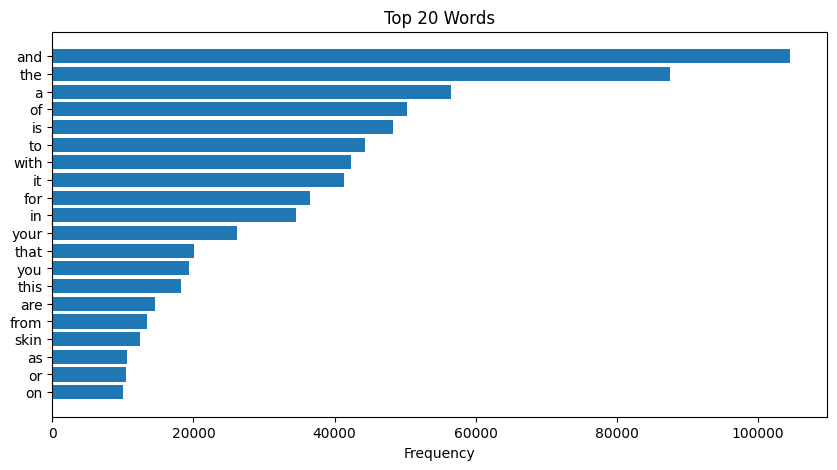

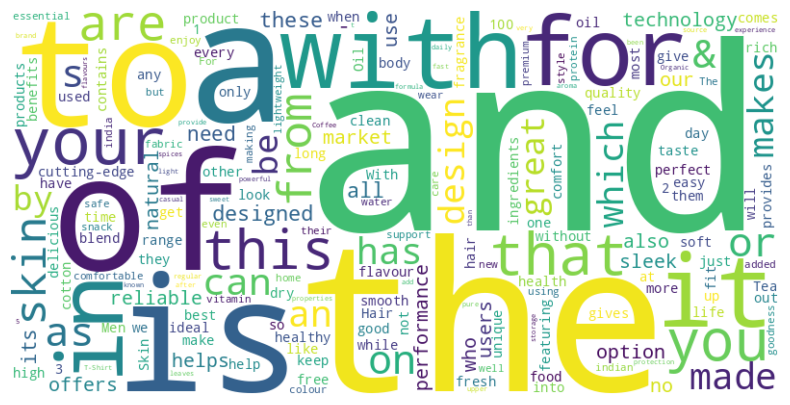

In [ ]:
all_words = " ".join(clean_Final_data["clean_description"]).split()
word_counts = Counter(all_words)
common_words = word_counts.most_common(20)

# Bar chart most frequent 20 words
words, counts = zip(*common_words)
plt.figure(figsize=(10,5))
plt.barh(words[::-1], counts[::-1])
plt.xlabel("Frequency")
plt.title("Top 20 Words")
plt.show()

# WordCloud
wc = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_counts)
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
clean_Final_data_model = process_for_model(Final_data, nlp)
save_path = os.path.expanduser("~/Documents/clean_Final_data_model.csv")
clean_Final_data_model.to_csv(save_path, index=False, encoding="utf-8")
print("Dataset Saved to : ", save_path)


Dataset Saved to :  /root/Documents/clean_Final_data_model.csv


In [ ]:
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel, pipeline
from nltk.corpus import wordnet
import tensorflow as tf
import nltk
import re
import traceback

nltk.download('punkt')
nltk.download('wordnet')

pipe = pipeline("text-generation", model="openai-community/gpt2")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Device set to use cpu


In [ ]:
for pkg in ("punkt", "wordnet", "omw-1.4"):
    try:
        nltk.data.find(f"corpora/{pkg}")
    except LookupError:
        print(f"Downloading NLTK package: {pkg} ...")
        nltk.download(pkg)


def get_word_info(word: str):
    """Return a dict with definition, examples (list), and synonyms (list). Always returns 'synonyms' key."""
    try:
        synsets = wordnet.synsets(word)
    except Exception as e:
        print("Warning: error accessing WordNet:", str(e))
        try:
            nltk.download("wordnet")
            synsets = wordnet.synsets(word)
        except Exception as e2:
            print("Failed to access WordNet after download:", e2)
            return {"definition": f"No definition found for '{word}'.", "examples": [], "synonyms": []}

    if not synsets:
        return {"definition": f"No definition found for '{word}'.", "examples": [], "synonyms": []}

    s = synsets[0]
    meaning = s.definition() or f"No definition found for '{word}'."
    examples = s.examples() or []
    synonyms = [lemma.name() for lemma in s.lemmas()] or []
    return {"definition": meaning, "examples": examples, "synonyms": synonyms}


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
def get_word_info(word):
    """
    Get the definition, examples, and synonyms of a word using WordNet.
    """
    synsets = wordnet.synsets(word)
    if not synsets:
        return {"definition": f"No definition found for {word}.", "examples": []}

    meaning = synsets[0].definition()
    examples = synsets[0].examples()
    synonyms = [lemma.name() for lemma in synsets[0].lemmas()]
    return {"definition": meaning, "examples": examples, "synonyms": synonyms}
    if not synsets:
        return {"definition": f"No definition found for '{word}'.", "examples": [], "synonyms": []}

    s = synsets[0]
    meaning = s.definition() or f"No definition found for '{word}'."
    examples = s.examples() or []
    synonyms = [lemma.name() for lemma in s.lemmas()] or []
    return {"definition": meaning, "examples": examples, "synonyms": synonyms}


In [ ]:
def clean_repetitions(text):
    text = re.sub(r'(\b\w+\b(?:\s+\b\w+\b){1,3})\s+\1+', r'\1', text)
    sentences = re.split(r'(?<=[.!?])\s+', text)
    seen = set()
    result = []
    for s in sentences:
        if s.lower().strip() not in seen:
            result.append(s.strip())
            seen.add(s.lower().strip())
    return ' '.join(result).strip()

In [ ]:
def generate_description(word: str, definition: str):
    """Use the pipeline; return a safe string on any error or if model not loaded."""
    if pipe is None:
        return "(generation model not loaded)"
    prompt = f"The word '{word}' refers to {definition}. It is commonly known as"
    try:
        out = pipe(
            prompt,
            max_length=80,
            temperature=0.8,
            top_p=0.9,
            do_sample=True,
            num_return_sequences=1
        )

        if isinstance(out, list) and len(out) > 0:
            return out[0].get("generated_text", "(no generated_text key)")
        return str(out)
    except Exception:
        traceback.print_exc()
        return "(generation failed)"


In [ ]:
if __name__ == "__main__":
    print("Interactive GPT-2 + WordNet (type 'exit' to quit)")
    while True:
        user_input = input("\nEnter a word or short phrase: ").strip()
        if user_input.lower() in ("exit", "quit"):
            print("Goodbye 👋")
            break
        if not user_input:
            print("Please type something (or 'exit').")
            continue

        info = get_word_info(user_input)
        print("\nDefinition:")
        print(" ", info.get("definition", "(none)"))

        syns = info.get("synonyms") or []
        if syns:
            # make sure all syns are strings
            syns = [str(s) for s in syns]
            print("Synonyms:", ", ".join(syns))
        else:
            print("Synonyms: None found")

        examples = info.get("examples") or []
        if examples:
            print("Example:", examples[0])
        else:
            print("Example: None found")

        print("\nGenerating AI description...")
        result = generate_description(user_input, info.get("definition", ""))
        print("\nGPT-2 result:\n", result)

Interactive GPT-2 + WordNet (type 'exit' to quit)

Enter a word or short phrase: hundi 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



Definition:
  No definition found for hundi.
Synonyms: None found
Example: None found

Generating AI description...

GPT-2 result:
 The word 'hundi' refers to No definition found for hundi.. It is commonly known as 'Hindi' or 'Hindi' by the Tamil Nadu community.

The word is used in Tamil Nadu, Sri Lanka and other states of the Sri Lanka region to refer to any part of the country. In Tamil Nadu, the word means 'Hindi' or 'Hindi' in a certain sense, with its usage in the context of the country. In other words, 'Hindi' means 'Hindi' and 'Hindi' is a Sanskrit word meaning 'Hindi' or 'Hindi' in this sense. The word has been used in Tamil Nadu in various forms as well as in other parts of the country. The word is also sometimes also used in Tamil Nadu in the sense of 'Hindi' or 'Hindi' in a certain sense.

A Hindi word meaning 'Hindi' or 'Hindi' in this sense.

In the case of Hindi, the term means 'hindi' or 'Hindi' in the sense of 'hindi' in the sense of the word.

The word has also been 